In [25]:
import findspark
findspark.init()
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F 
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import random
import seaborn as sns
from pyspark.sql.types import StringType
import pyspark.sql.functions as f
from pyspark.sql.functions import concat_ws,col, avg
import numpy as np
from sklearn.metrics import r2_score
import pickle
import joblib

from datetime import datetime

from sklearn.preprocessing import RobustScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
from sklearn.model_selection import train_test_split


# begin Pyspark session

In [3]:


spark = SparkSession.builder \
    .appName("Redshift Connection with PySpark") \
    .config("spark.jars", "redshift-jdbc42-2.1.0.20.jar") \
    .getOrCreate()

conf = SparkConf()
conf.set("spark.driver.maxResultSize", "2g")

redshift_url ="jdbc:redshift://cars-cluster.c7utbjvxgyyz.eu-north-1.redshift.amazonaws.com:5439/cars"

redshift_properties = {
    "user": "aya",
    "password": "aya.mo.9.A",
    "driver": "com.amazon.redshift.Driver"
}

cars_query = "(SELECT cars.*, classes.model, classes.brand, classes.class, body.body FROM cars.prod.cars_data as cars join cars.prod.cars_classes_data as classes on cars.class_id = classes.class_id join cars.prod.cars_body_data as body on classes.model = body.model and classes.brand = body.brand)"

car_df = spark.read.jdbc(redshift_url, cars_query,
                         properties=redshift_properties)


car_df = car_df.repartition(1000)  # Adjust the number of partitions as needed


23/11/05 02:21:38 WARN Utils: Your hostname, Aya-MacBook.local resolves to a loopback address: 127.0.0.1; using 192.168.1.3 instead (on interface en0)
23/11/05 02:21:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/11/05 02:21:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Cleaning data

## Helper functions

In [4]:


def find_gover(city): 
    governorate = {'Cairo': ['Cairo', 'Mohandessin', 'Nasr city', 'El Marg', 'Sheraton', 
                         'Heliopolis', 'El Manial', 'Mokattam', 'El Gamaleya', 'Al Shorouk',
                         'Shobra', 'Tagamo3 - New Cairo', 'New Administrative Capital',
                         'Badr City', 'Zamalek','Ain Shams', 'Madinaty', 'Maadi', 'Warraq',
                         'El Katameya', 'El Salam City'], 
               'Giza': ['Imbaba', 'Kerdasa', 'Dokki', 'Saft El Laban','El Haram', 'Sheikh Zayed City',
                        '6 October', 'Giza', 'Pyramids Gardens'],
               'Dakahlia': ['Mit Ghamr', 'El Senbellawein', 'Dikirnis', 'Mansoura', 'Dakahlia'],
               'Red Sea':['Ras Gharib', 'Safaga', 'Hurghada', 'El Gouna', 'Red Sea'],
               'Luxor': ['Luxor'],
               'Sharkia': ['Dyarb Negm', 'Bilbeis'],
               'Damietta': ['Damietta'],
               'Monufia': ['Sadat City', 'Shibin el Kom', 'El Bagour', 'Ashmoun', 'Menouf', 'Quesna',
                            'Monufia', 'Tala'],
               'Alexandria': ['Alexandria', 'Borg el arab', 'Amreya', 'Abu Qir', 'Agamy'],
               'Qalubia': ['Kafr Shukr', 'Banha', 'Khanka', 'Touhk', 'El Qanater El Khayreya', 'Qalyub',
                           'Shibin El Qanater', 'Obour City', 'Qalyubia'],
               'Kafr el-Sheikh': ['Kafr el-Sheikh'],
               'El Minya': ['El Minya'],
               'ALGharbia': ['El Mahalla', 'Kafr El Zayat', 'Zefta', 'Tanta', 'Gharbia'],
               'ALSharqia': ['Faqous', 'Minya Al Qamh', 'Zagazig','Sharqia', 'Abu Kabir', '10th of Ramadan'],
               'Helwan': ['Helwan'], 
               'Aswan': ['Kom Ombo', 'Aswan'],
               'Matrouh': ['Marsa Matrouh', 'El-Alamein'],
               'South Sinai': ['Sharm el-Sheikh'],
               'North Sinai': ['El-Arish'],
               'Sohag': ['Sohag'],
               'Ismailia': ['Ismailia'],
               'Suez': ['Suez'], 
               'Qena': ['Qena'], 
               'ElBeheira': ['Damanhur', 'Kom Hamada', 'Edku', 'Kafr el-Dawwar', 'Abu Hummus', 'Rosetta',
                             'Beheira'], 
               'Beni Suef': ['Beni Suef'],
               'El Wadi El Gedid': ['El Wadi El Gedid'],
               'Faiyum': ['Faiyum'],
               'Asyut':['Asyut'],
               'Port Said': ['Port Said']
               
               
               }
    
    for gover, cities_list in governorate.items():
        if city in cities_list:
            return gover 

    return '' 



def clean_class(class_name):
    cleaning_dict = {'Automtic':'', 
                     'Automatic':'',
                     'automatic': '',
                     'A/T': '',
                     'F/O' : 'full option',
                     'f/o' : 'full option',
                     'None': 'basic',
                     'M/T': '',
                     ' /': '',
                     'Manual': '',
                     'manual': ''}
    for key, value in cleaning_dict.items():
        class_name = class_name.replace(key, value)
    return class_name.strip().lower()



find_gover_f = F.udf(find_gover, StringType()) 
clean_class_f = F.udf(clean_class, StringType()) 




23/11/05 02:21:49 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Add new columns

In [5]:
car_df = car_df.withColumn('governorate', find_gover_f('city'))
car_df = car_df.withColumn('class_new', clean_class_f('class'))


## Cleanin columns

In [8]:
car_df = car_df.drop('car_id', 'class_id', 'fingerprint')
car_df = car_df.filter((car_df.km > 0) & (car_df.price > 0) & (car_df.model_year > 1900))
car_df = car_df.replace(['', 'None', 'basic'], ['standard', 'standard', 'standard'], subset=['class_new'])
car_df = car_df.replace(['Sedan', 'Minivan', 'sports car'], ['sedan','mini Vans',  'sports'])

# General Analytics

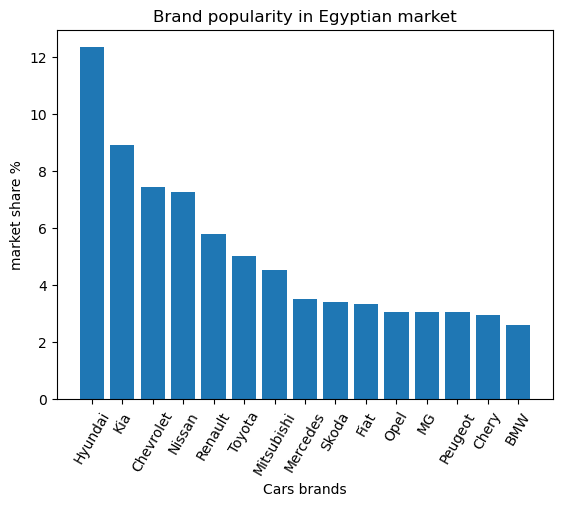

In [ ]:
#top brands
brands = car_df.groupBy('brand').count().orderBy('count', ascending=False).collect()
total = car_df.count()
categories = []
values = []
for i in range(len(brands)):
    categories.append(brands[i]['brand'])
    values.append(brands[i]['count'] / total * 100)

plt.bar(categories[:15], values[:15])

plt.xlabel("Cars brands")
plt.ylabel("market share %")
plt.title("Brand popularity in Egyptian market")
plt.xticks(rotation=60)

plt.show()



@@ we can see that asain and european cars are the most popular in egypt

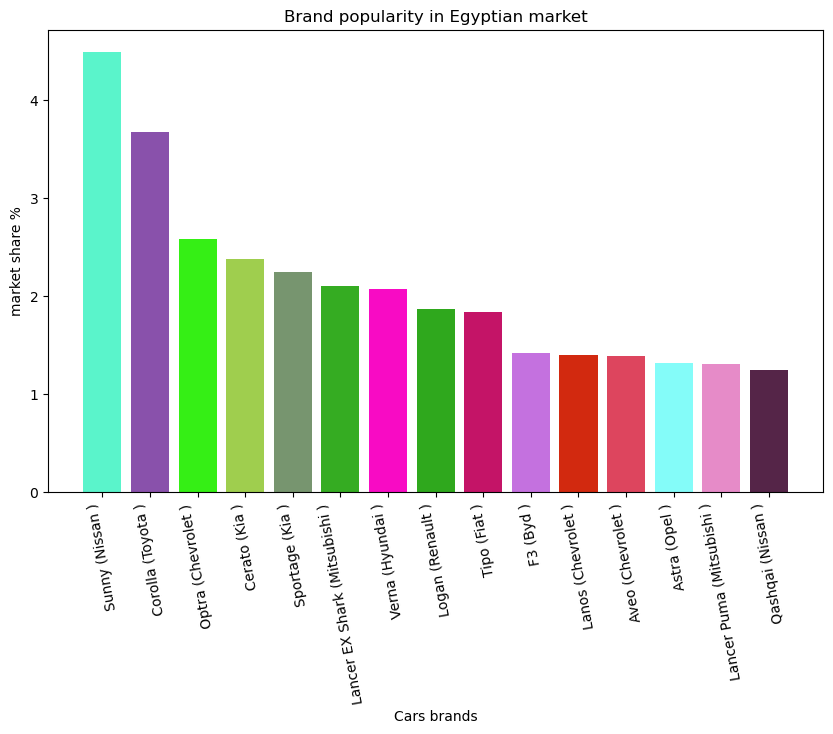

In [ ]:
#top car model
brands = car_df.groupBy('brand', 'model').count().orderBy('count', ascending=False).collect()
total = car_df.count()
categories = []
values = []

for i in range(len(brands)):
    categories.append(f"{brands[i]['model']} ({brands[i]['brand']} )")
    values.append(brands[i]['count'] / total * 100)


plt.figure(figsize=(10, 6))  
colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in categories]
plt.bar(categories[:15], values[:15], color=colors)


plt.xlabel("Cars brands")
plt.ylabel("market share %")
plt.title("Brand popularity in Egyptian market")
plt.xticks(rotation=100)

plt.show()

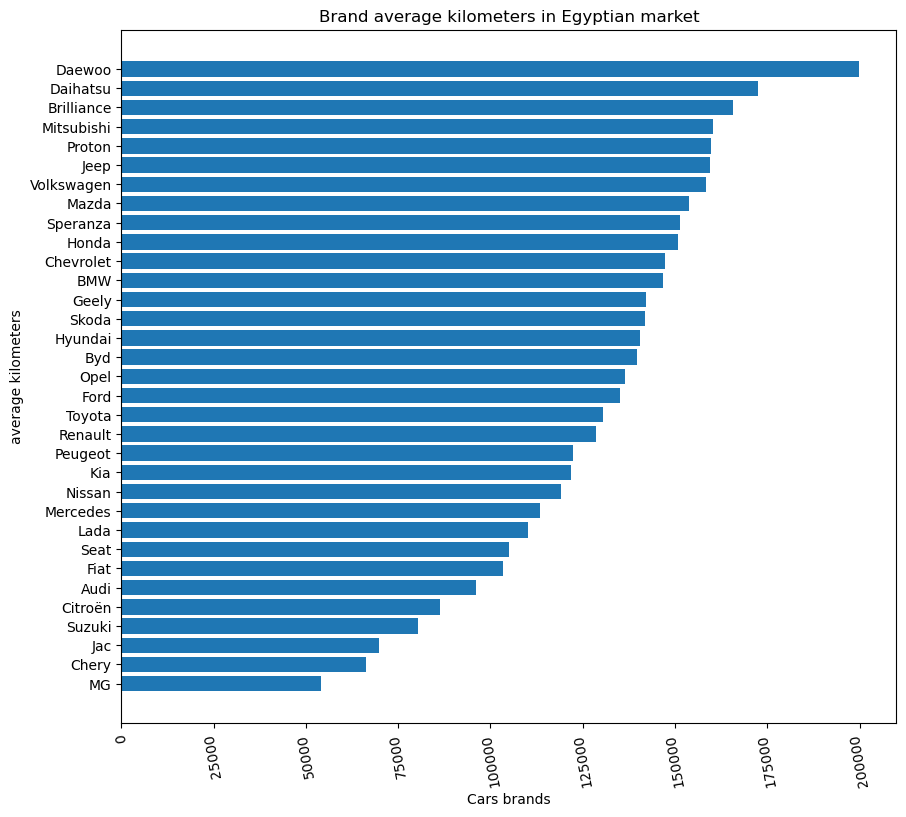

In [ ]:
from pyspark.sql.functions import avg, count

avg_km = car_df.groupBy('brand').agg(avg('km'))
count_group = car_df.groupBy('brand').agg(count('*').alias('count'))
avg_km = count_group.join(avg_km, ['brand'])
avg_km = avg_km.filter('count >100').orderBy('avg(km)', ascending=True).collect()


categories = []
values = []

for i in range(len(avg_km)):
    categories.append(avg_km[i]['brand'])
    values.append(avg_km[i]['avg(km)'])


plt.figure(figsize=(10, 9))  
plt.barh(categories, values)


plt.xlabel("Cars brands")
plt.ylabel("average kilometers")
plt.title("Brand average kilometers in Egyptian market")
plt.xticks(rotation=100)

plt.show()


@@ Average kilometer per brand gives us insights about level of satisfaction with the car (more kilometer ididcates customer satisfaction). We can see that the least used cars befor selling it is the chinese brands (MG, Haval, Chery, Jetour, and Jac)

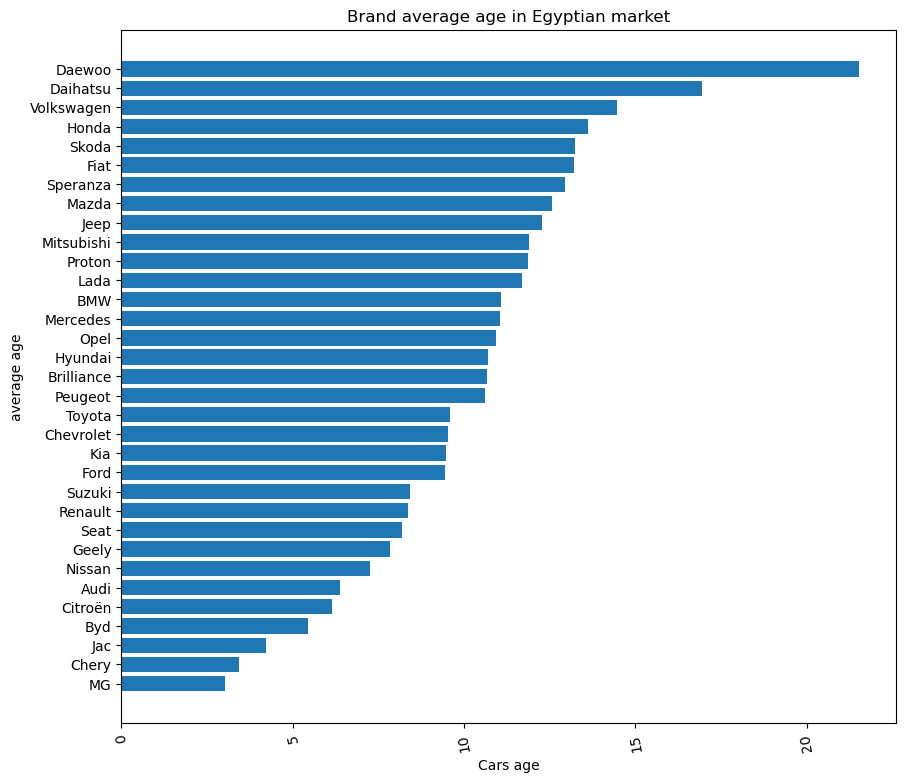

In [ ]:
# average car age

date = datetime.now()
year = int(date.strftime("%Y"))

year_df = car_df.withColumn('age', year+1 - car_df.model_year)
avg_age = year_df.groupBy('brand').agg(avg('age'))
count_group = year_df.groupBy('brand').agg(count('*').alias('count'))
avg_age = count_group.join(avg_age, ['brand'])
avg_age = avg_age.filter('count >100').orderBy('avg(age)', ascending=True).collect()


categories = []
values = []

for i in range(len(avg_age)):
    categories.append(avg_age[i]['brand'])
    values.append(avg_age[i]['avg(age)'])

plt.figure(figsize=(10, 9))  
plt.barh(categories, values)


plt.xlabel("Cars age")
plt.ylabel("average age")
plt.title("Brand average age in Egyptian market")
plt.xticks(rotation=100)
plt.show()


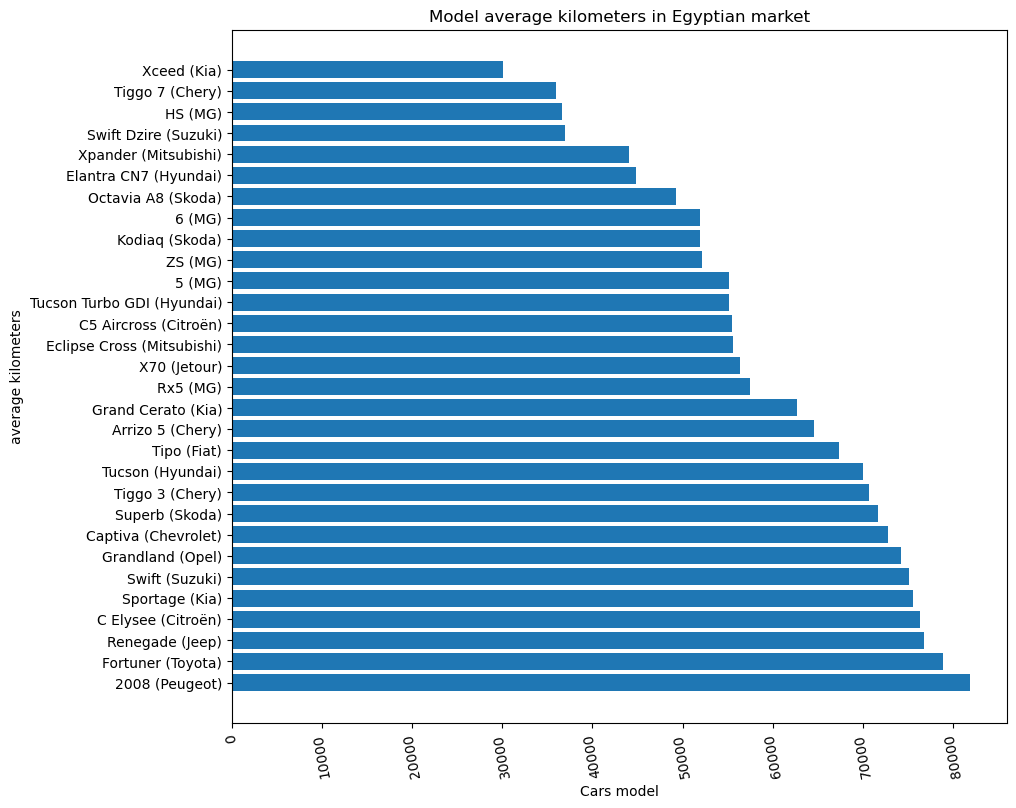

In [ ]:

avg_model_km = car_df.groupBy('brand' , 'model').agg(avg('km'))
count_group = car_df.groupBy('brand', 'model').agg(count('*').alias('count'))
avg_model_km = count_group.join(avg_model_km, ['brand', 'model'])
avg_model_km = avg_model_km.filter('count >40').orderBy('avg(km)', ascending=True).collect()

categories = []
values = []

for i in range(len(avg_model_km)):
    categories.append(f"{avg_model_km[i]['model']} ({avg_model_km[i]['brand']})")
    values.append(avg_model_km[i]['avg(km)'])

categories = categories[:30]
values = values[:30]
plt.figure(figsize=(10, 9))  
plt.barh(categories[::-1], values[::-1])


plt.xlabel("Cars model")
plt.ylabel("average kilometers")
plt.title("Model average kilometers in Egyptian market")
plt.xticks(rotation=100)

plt.show()



In [ ]:
# cars distribution per governorate
import plotly.express as px

cars_per_gov = car_df.groupBy('governorate').agg(count('*').alias('count'))
tot_cars = car_df.count()
cars_per_gov = cars_per_gov.withColumn('cars/gov%', f.col('count')/tot_cars * 100)
cars_per_gov_df = cars_per_gov.select('governorate', 'cars/gov%').filter("governorate !=''").orderBy('cars/gov%', ascedning=False)

fig = px.treemap(data_frame = cars_per_gov_df, 
                  path=['governorate', ], 
                  color_continuous_scale='deep',
                 values = 'cars/gov%',
                 color='cars/gov%'
                 )

fig.update_layout(width=900, height=600)
fig.show()

In [ ]:
# car brands distribution per governorate
import plotly.express as px

model_per_gov = car_df.groupBy('brand', 'governorate').agg(count('*').alias('count'))
tot_brand = car_df.groupBy('governorate').agg(count('*').alias('total_per_gov'))
model_per_gov = model_per_gov.join(tot_brand, 'governorate')
model_per_gov = model_per_gov.withColumn('brand/gov%', f.col('count')/f.col('total_per_gov')*100)
model_per_gov_df = model_per_gov.select('governorate', 'brand','brand/gov%', 'total_per_gov').filter("governorate !=''").orderBy('total_per_gov', ascedning=False)

fig = px.treemap(data_frame = model_per_gov_df, 
                  path=['governorate', 'brand'], 
                  color_continuous_scale='deep',
                 values = 'brand/gov%',
                 color='brand/gov%'
                 )

fig.update_layout(width=1400, height=700)
fig.show()

/var/folders/18/bfxv49yn02qg3c3v6g5wgy7w0000gn/T/ipykernel_30210/392670457.py:50: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



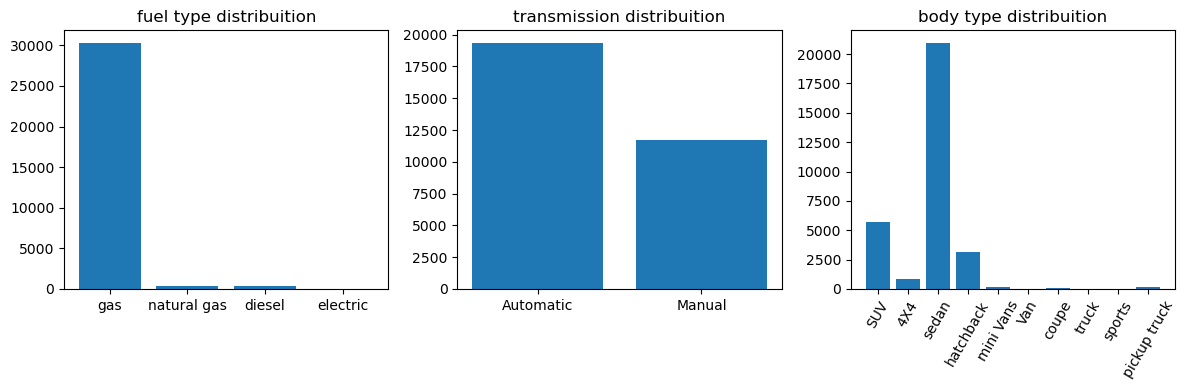

In [ ]:
fuel = car_df.groupBy('fuel').count().collect()

fuel_categories = []
fuel_values = []

for i in range(len(fuel)):
    fuel_categories.append(fuel[i]['fuel'])
    fuel_values.append(fuel[i]['count'])

transmission = car_df.groupBy('transmission').count().collect()

transmission_categories = []
transmission_values = []

for i in range(len(transmission)):
    transmission_categories.append('Automatic' if transmission[i]['transmission'] else 'Manual')
    transmission_values.append(transmission[i]['count'])


body = car_df.groupBy('body').count().collect()

body_categories = []
body_values = []

for i in range(len(body)):
    body_categories.append(body[i]['body'])
    body_values.append(body[i]['count'])



import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)

# fuel distribuition
ax1 = plt.subplot(gs[0])
ax1.bar(fuel_categories, fuel_values)
ax1.set_title('fuel type distribuition')

# transmission type distribuition
ax2 = plt.subplot(gs[1])
ax2.bar(transmission_categories, transmission_values)
ax2.set_title('transmission distribuition')

# body type distribuition
ax3 = plt.subplot(gs[2])
ax3.bar(body_categories, body_values)
ax3.set_title('body type distribuition')
ax3.set_xticklabels(body_categories, rotation=60)

plt.tight_layout()
plt.show()


# descirbe care price distribuiton

In [12]:
prices_df = car_df.select('price')
prices_df.summary().show()


+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|            31116|
|   mean|685155.3791939839|
| stddev|662935.9490733645|
|    min|            20000|
|    25%|           310000|
|    50%|           520000|
|    75%|           830000|
|    max|         24000000|
+-------+-----------------+



/var/folders/18/bfxv49yn02qg3c3v6g5wgy7w0000gn/T/ipykernel_30210/461363296.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




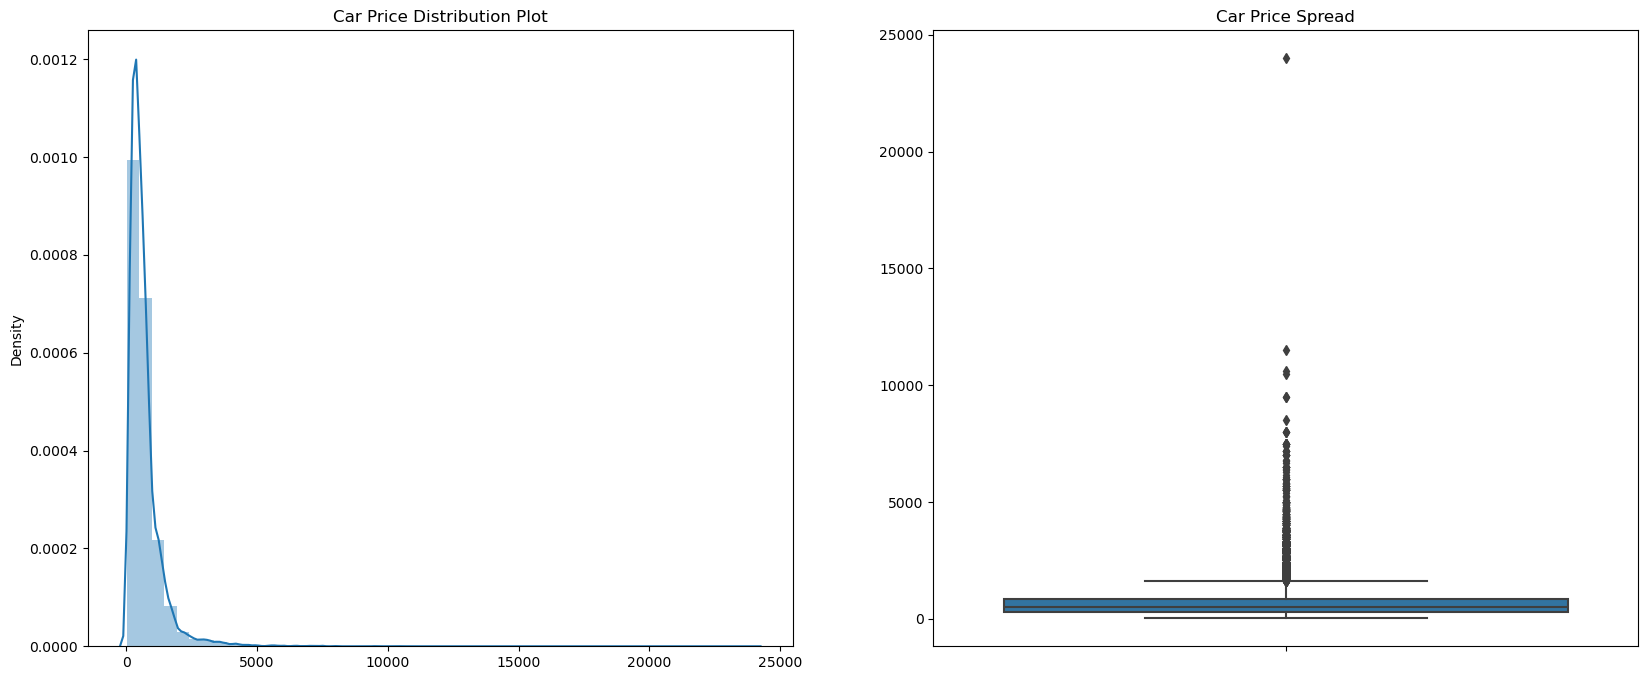

In [ ]:


prices_df = car_df.select('price').collect()
prices = [prices_df[i]['price'] / 1000 for i in range(len(prices_df))]
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(prices)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=prices)

plt.show()

In [13]:
#remove price outlier
car_df.select('brand', 'model', 'price', 'model_year', 'km').filter('price > 12000000').show()
# there is only one care above 12000000... we can remove it
car_df = car_df.filter('price < 12000000')

+-------+----------+--------+----------+---+
|  brand|     model|   price|model_year| km|
+-------+----------+--------+----------+---+
|Ferrari|F8 Tributo|24000000|      2022|800|
+-------+----------+--------+----------+---+



/var/folders/18/bfxv49yn02qg3c3v6g5wgy7w0000gn/T/ipykernel_30210/3770560991.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




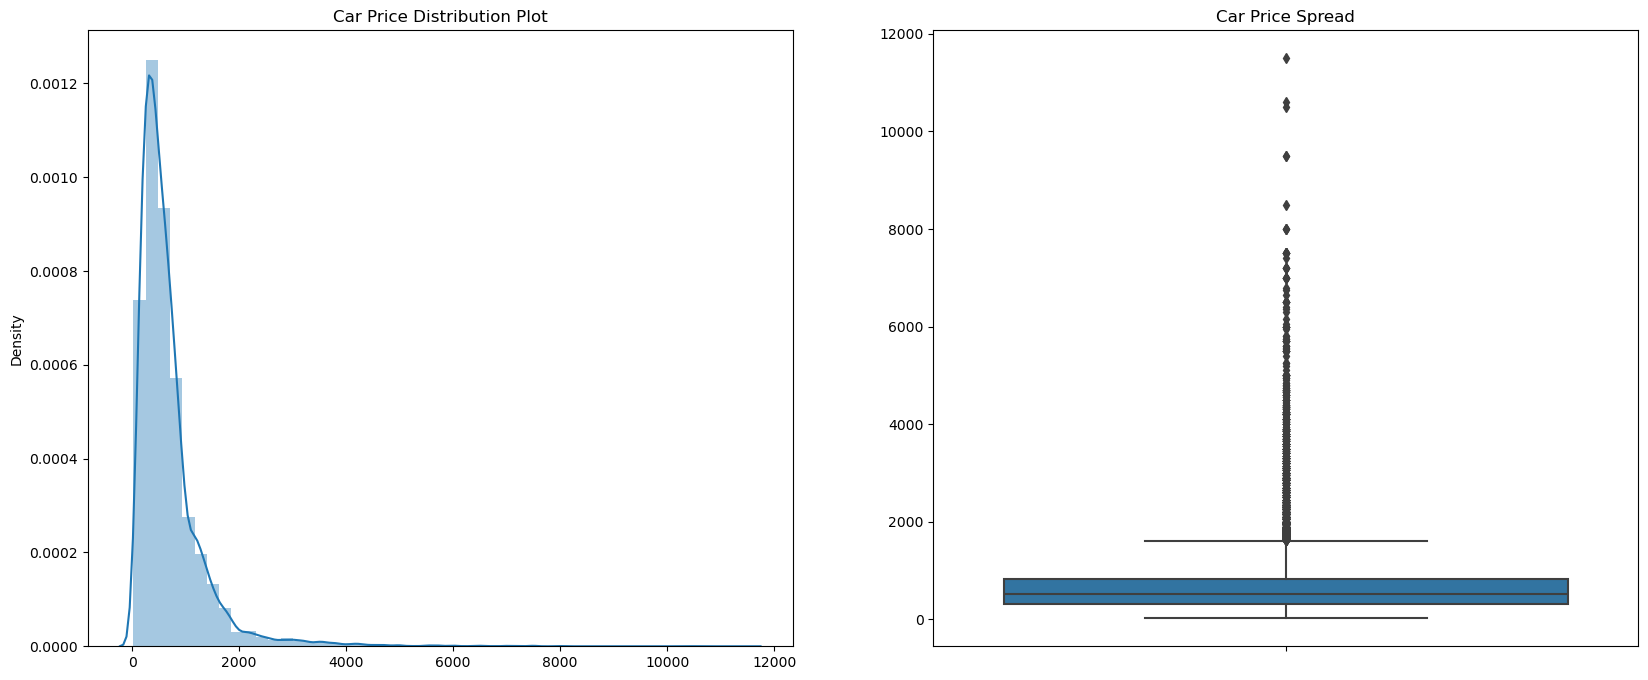

In [ ]:

prices_df = car_df.select('price').collect()
prices = [prices_df[i]['price'] / 1000 for i in range(len(prices_df))]
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(prices)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=prices)

plt.show()

## average price per categorical data(brand, transmission, body) 


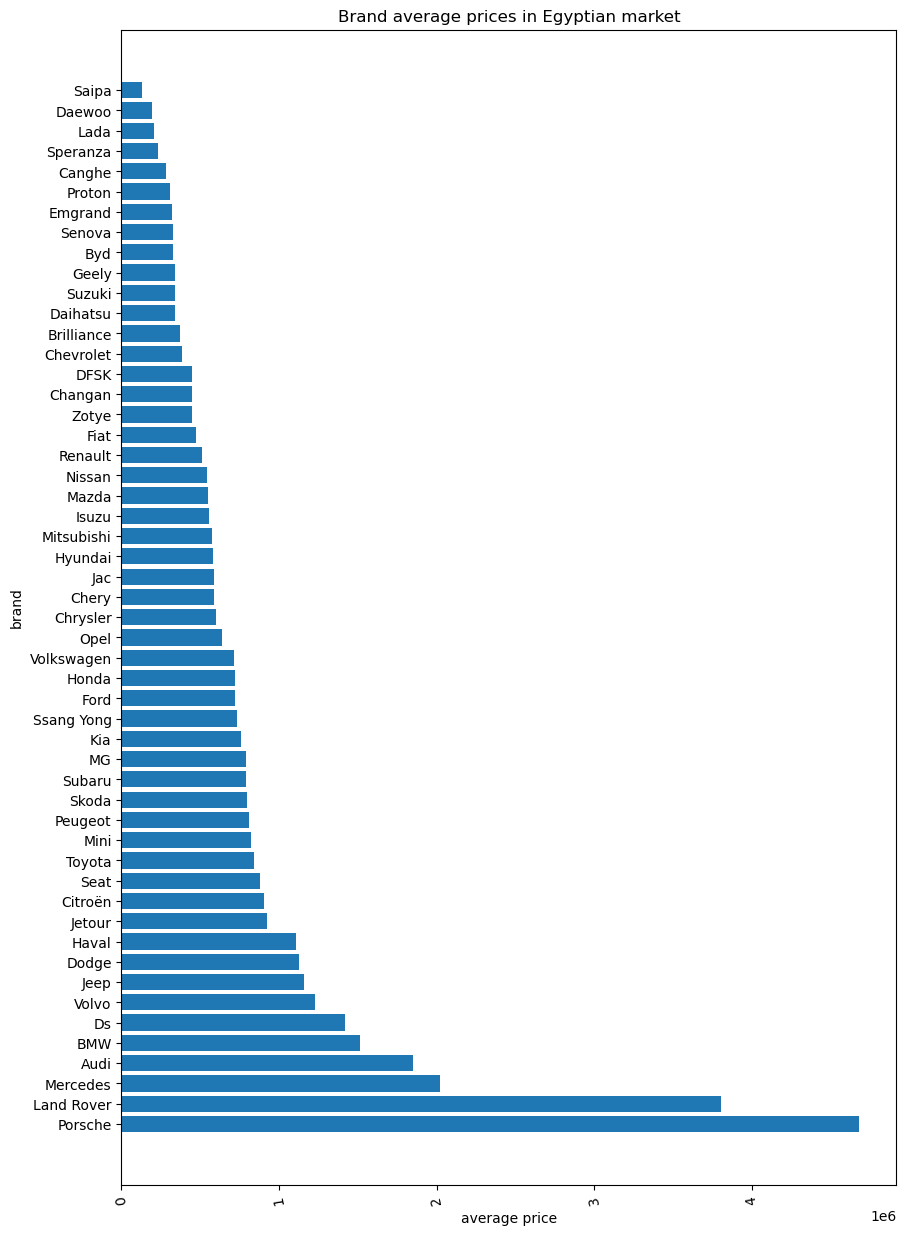

In [ ]:
price_per_brand_df = car_df.groupBy('brand').agg(avg('price'), count('brand').alias('count'))
price_per_brand_df = price_per_brand_df.filter('count > 20').orderBy('avg(price)', ascending=False)
price_per_brand_list =price_per_brand_df.collect()
brands = []
avg_price = []

for i in range(len(price_per_brand_list)):
    brands.append(price_per_brand_list[i]['brand'])
    avg_price.append(price_per_brand_list[i]['avg(price)'])


plt.figure(figsize=(10, 15))  
plt.barh(brands, avg_price)
plt.xlabel("average price")
plt.ylabel("brand")
plt.title("Brand average prices in Egyptian market")
plt.xticks(rotation=100)

plt.show()

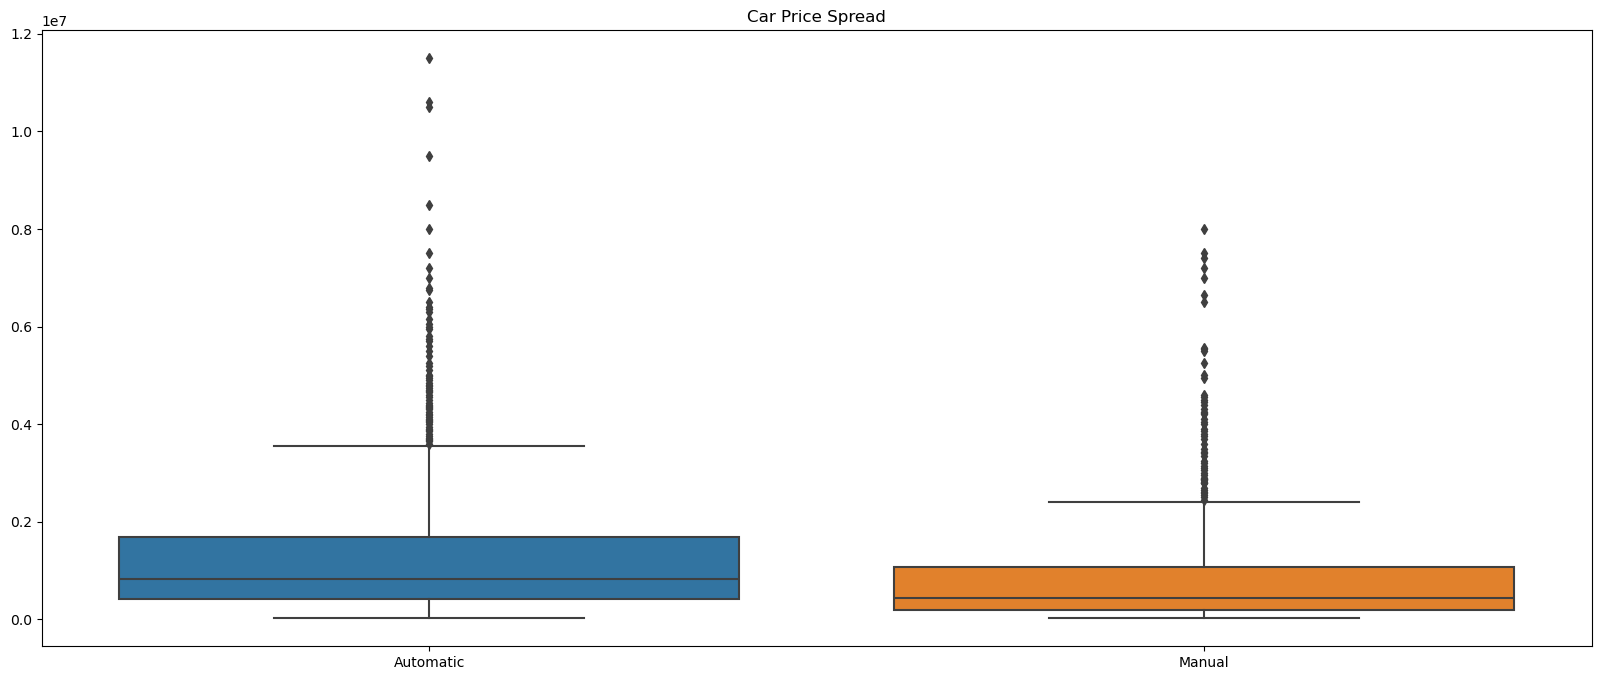

In [ ]:
# price per transmission
price_per_transmissionlist =car_df.groupBy('transmission', 'price').count().collect()
transmission = []
avg_price = []

for i in range(len(price_per_transmissionlist)):
    transmission.append('Automatic' if price_per_transmissionlist[i]['transmission'] else 'Manual')
    avg_price.append(price_per_transmissionlist[i]['price'])


plt.figure(figsize=(20,8))

plt.title('Car Price Spread')
sns.boxplot(x = transmission, y=avg_price)

plt.show()

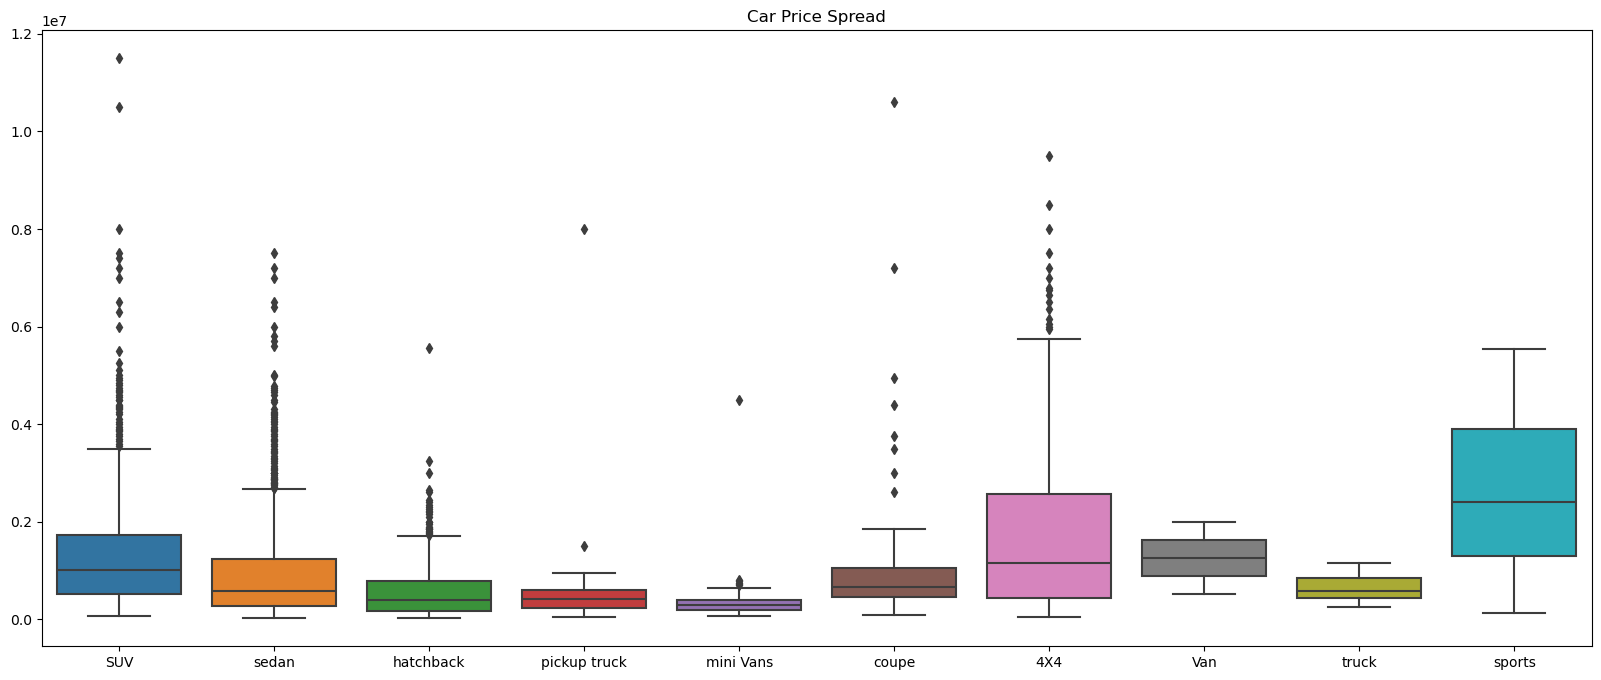

In [ ]:
# price per body type
price_per_body =car_df.groupBy('body', 'price').count().collect()
body = []
avg_price = []

for i in range(len(price_per_body)):
    body.append(price_per_body[i]['body'])
    avg_price.append(price_per_body[i]['price'])


plt.figure(figsize=(20,8))

plt.title('Car Price Spread')
sns.boxplot(x = body, y=avg_price)

plt.show()

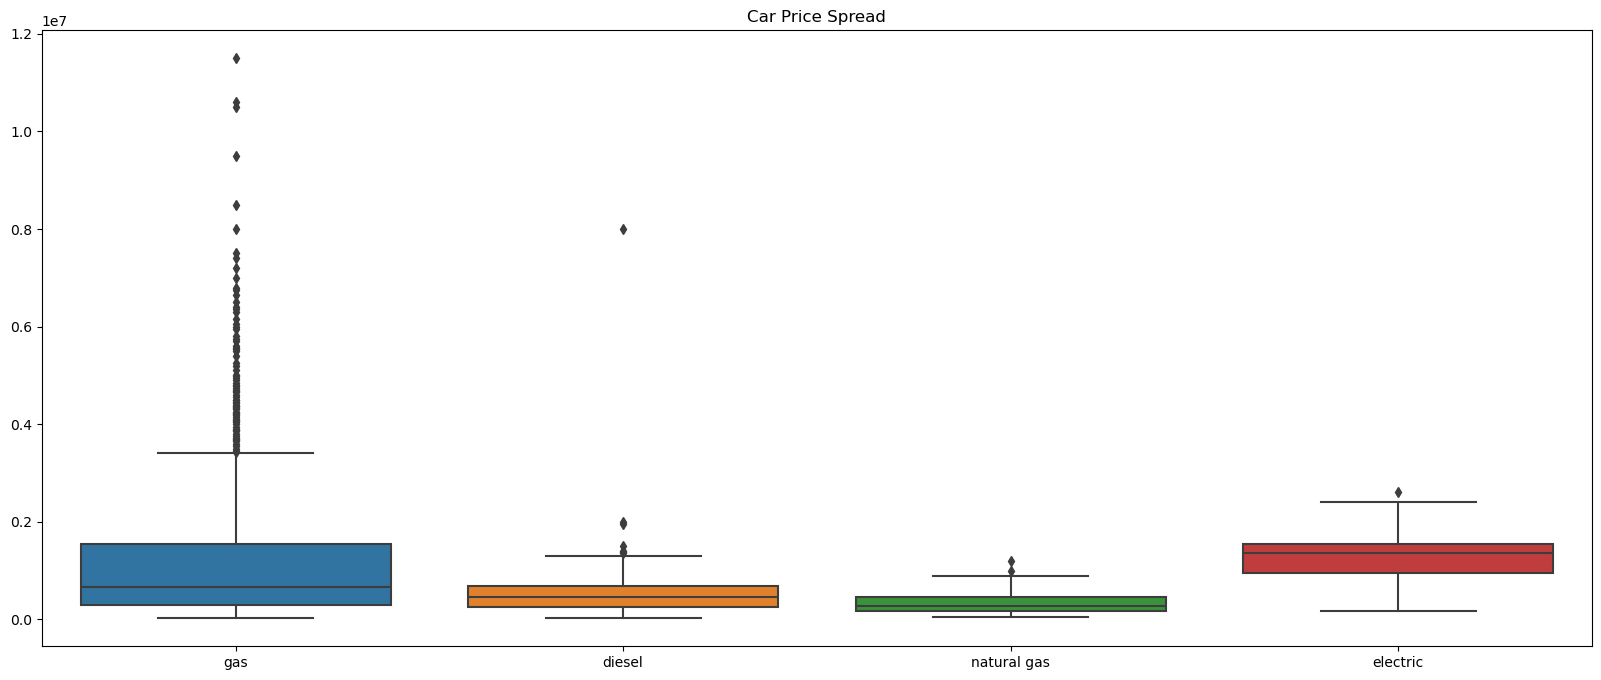

In [ ]:
# price per fule type
price_per_fuel =car_df.groupBy('fuel', 'price').count().collect()
fuel = []
avg_price = []

for i in range(len(price_per_fuel)):
    fuel.append(price_per_fuel[i]['fuel'])
    avg_price.append(price_per_fuel[i]['price'])


plt.figure(figsize=(20,8))

plt.title('Car Price Spread')
sns.boxplot(x = fuel, y=avg_price)

plt.show()

# Price relation with numerical values (model year and km)

## model year stat

/var/folders/18/bfxv49yn02qg3c3v6g5wgy7w0000gn/T/ipykernel_30210/1445788523.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




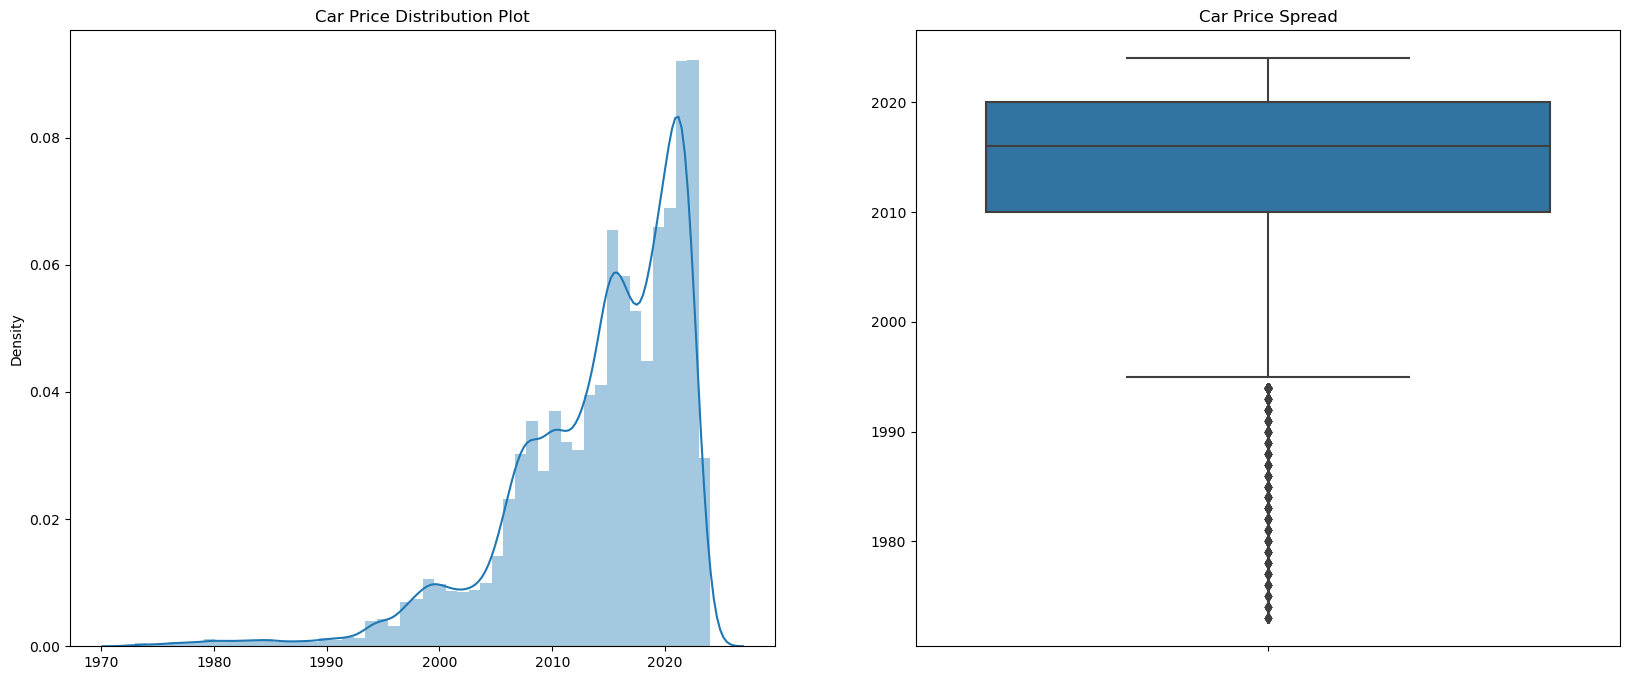

In [ ]:
model_df = car_df.select('model_year').collect()
model = [int(model_df[i]['model_year'] ) for i in range(len(model_df))]
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(model)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=model)
plt.show()


In [14]:
#filter out 2024 models that have large kilometer usage (most probably this will be noise data)
car_df = car_df.filter('!(model_year = 2024 and km > 100)')



### correlation between year and price

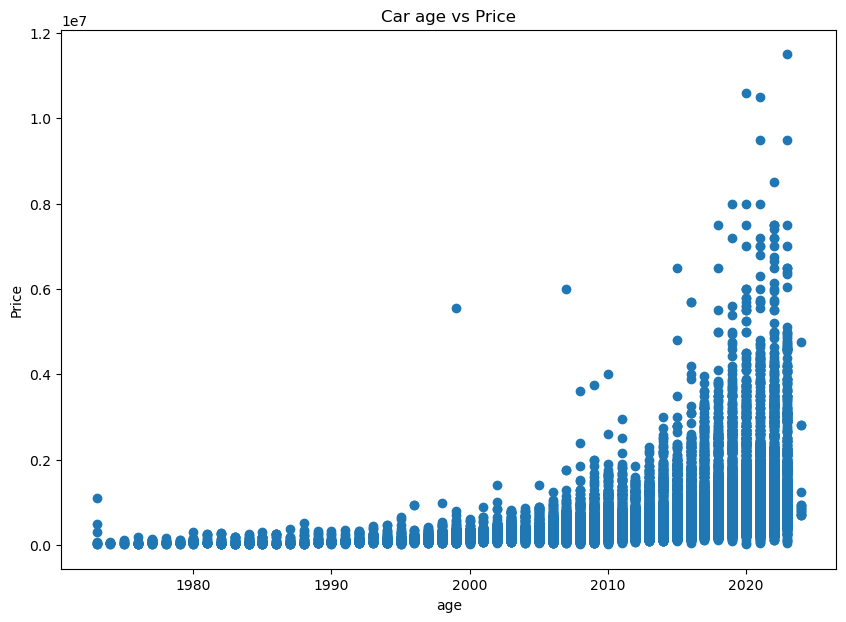

In [ ]:
year_df = car_df.select('model_year', 'price').collect()
year = []
price = []

for i in range(len(year_df)):
    year.append(year_df[i]['model_year'])
    price.append(year_df[i]['price'])

plt.figure(figsize=(10,7))
plt.scatter(year, price)
plt.title('Car age vs Price')
plt.ylabel('Price')
plt.xlabel('age')

plt.show()


in general there seems to be no direct correlation between car age and price. However, we can test on specific car model, or brand to see if there is an effect

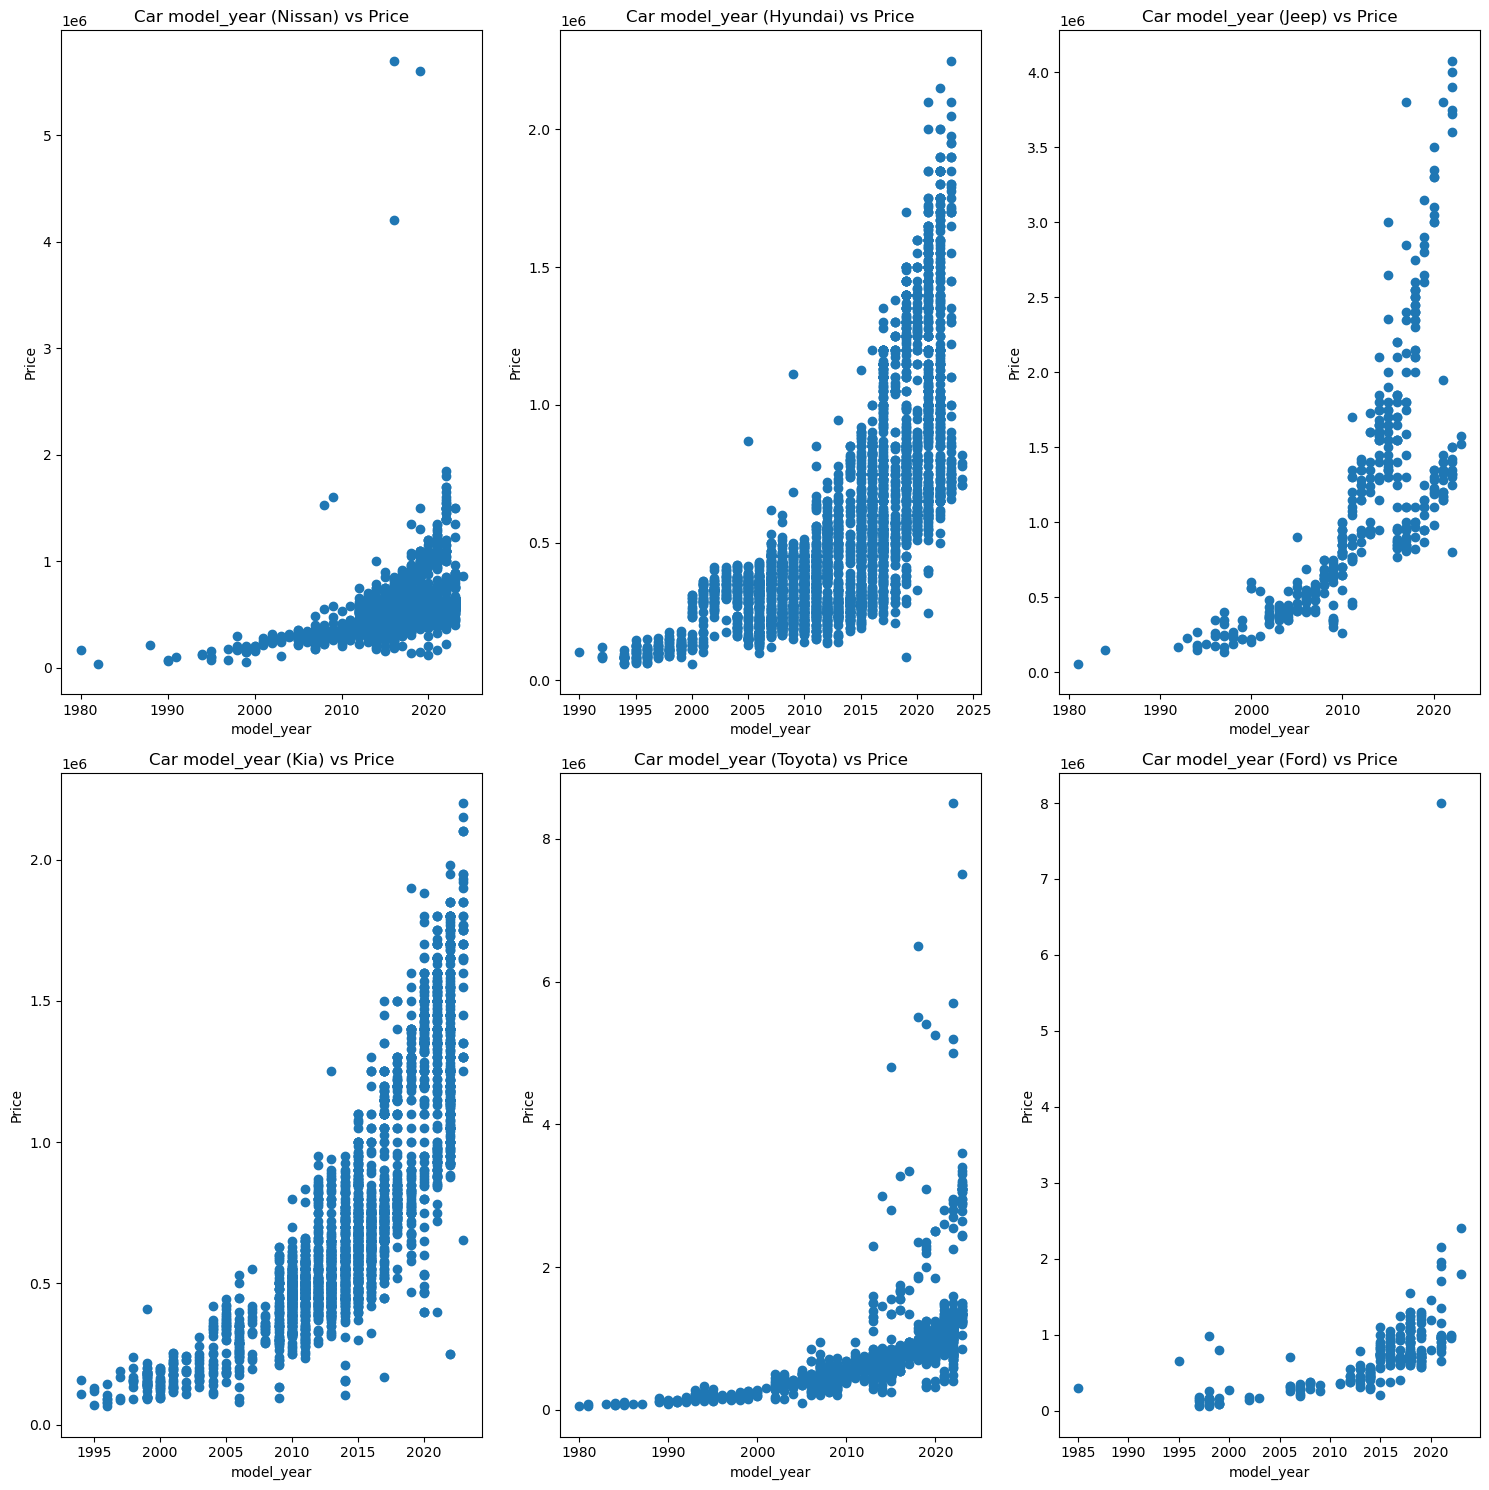

In [ ]:
#choose the most popular brand nissan sunny
def plot_scatter(brand, category, grid):
    df = car_df.select(category, 'price').where(f"brand = '{brand}'").collect()
    category_list = []
    price = []

    for i in range(len(df)):
        category_list.append(df[i][category])
        price.append(df[i]['price'])

    plt.subplot(gs[grid])

    plt.scatter(category_list, price)
    plt.title(f'Car {category} ({brand}) vs Price')
    plt.ylabel('Price')
    plt.xlabel(category)

plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2, 3)

plot_scatter('Nissan', 'model_year', 0)
plot_scatter('Hyundai', 'model_year', 1)
plot_scatter('Jeep', 'model_year', 2)
plot_scatter('Kia', 'model_year', 3)
plot_scatter('Toyota', 'model_year', 4)
plot_scatter('Ford', 'model_year', 5)


plt.tight_layout()

We can see that dorect correlation between car age and price begin to be more clear whenwe differntiated the brands

## km stat


/var/folders/18/bfxv49yn02qg3c3v6g5wgy7w0000gn/T/ipykernel_30210/1940085424.py:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




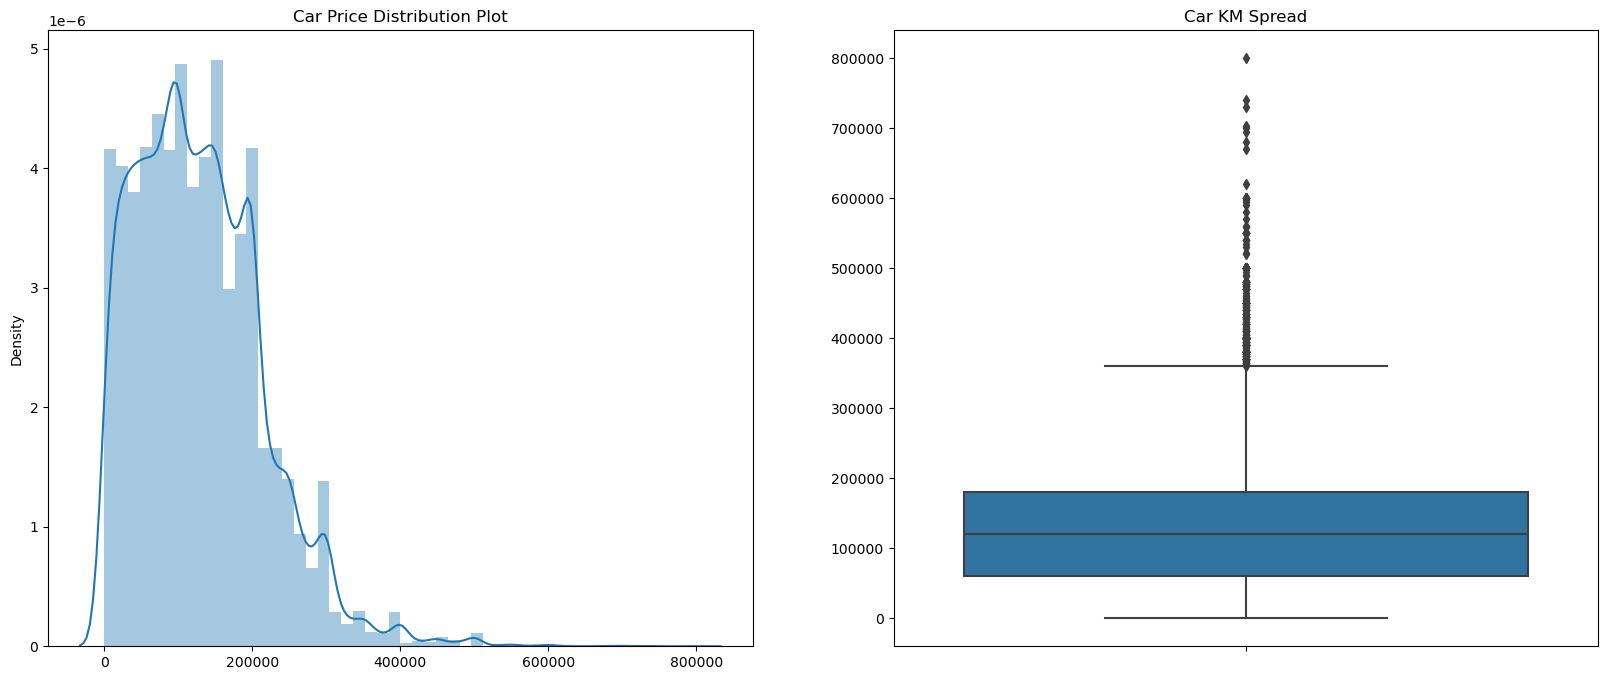

+-------+-----------------+
|summary|               km|
+-------+-----------------+
|  count|            31084|
|   mean| 128819.649819843|
| stddev|86220.77109175212|
|    min|                1|
|    25%|            61000|
|    50%|           120000|
|    75%|           180000|
|    max|           800000|
+-------+-----------------+



In [ ]:
km_df = car_df.select('km').collect()
km = [int(km_df[i]['km'] ) for i in range(len(km_df))]


plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(km)

plt.subplot(1,2,2)
plt.title('Car KM Spread')
sns.boxplot(y=km)
plt.show()
car_df.select('km').summary().show()

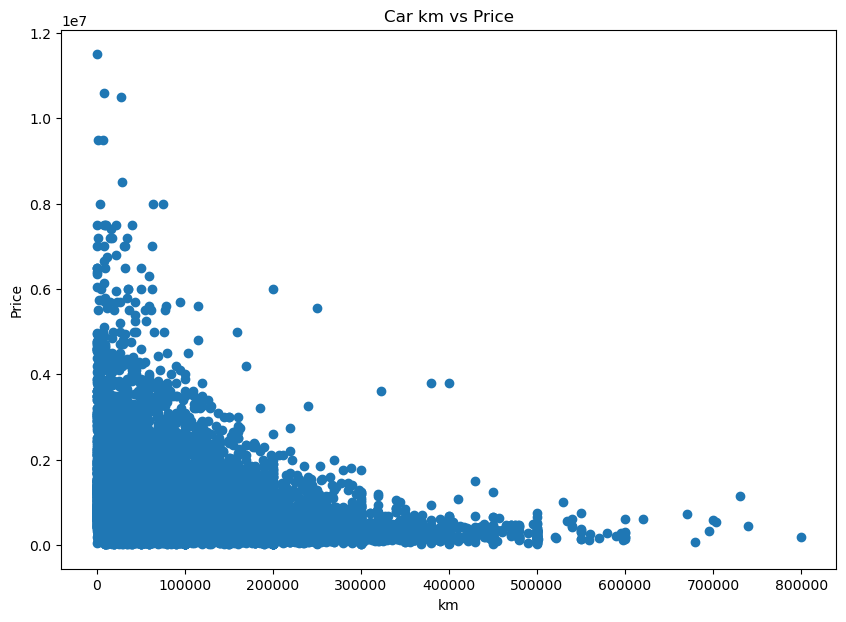

In [ ]:
#corelation bet price and km

km_df = car_df.select('km', 'price').collect()
km = []
price = []

for i in range(len(km_df)):
    km.append(km_df[i]['km'])
    price.append(km_df[i]['price'])

plt.figure(figsize=(10,7))
plt.scatter(km, price)
plt.title('Car km vs Price')
plt.ylabel('Price')
plt.xlabel('km')

plt.show()


Same as car age, there seems inverse relation bet km and price which can be more clear upon each brand

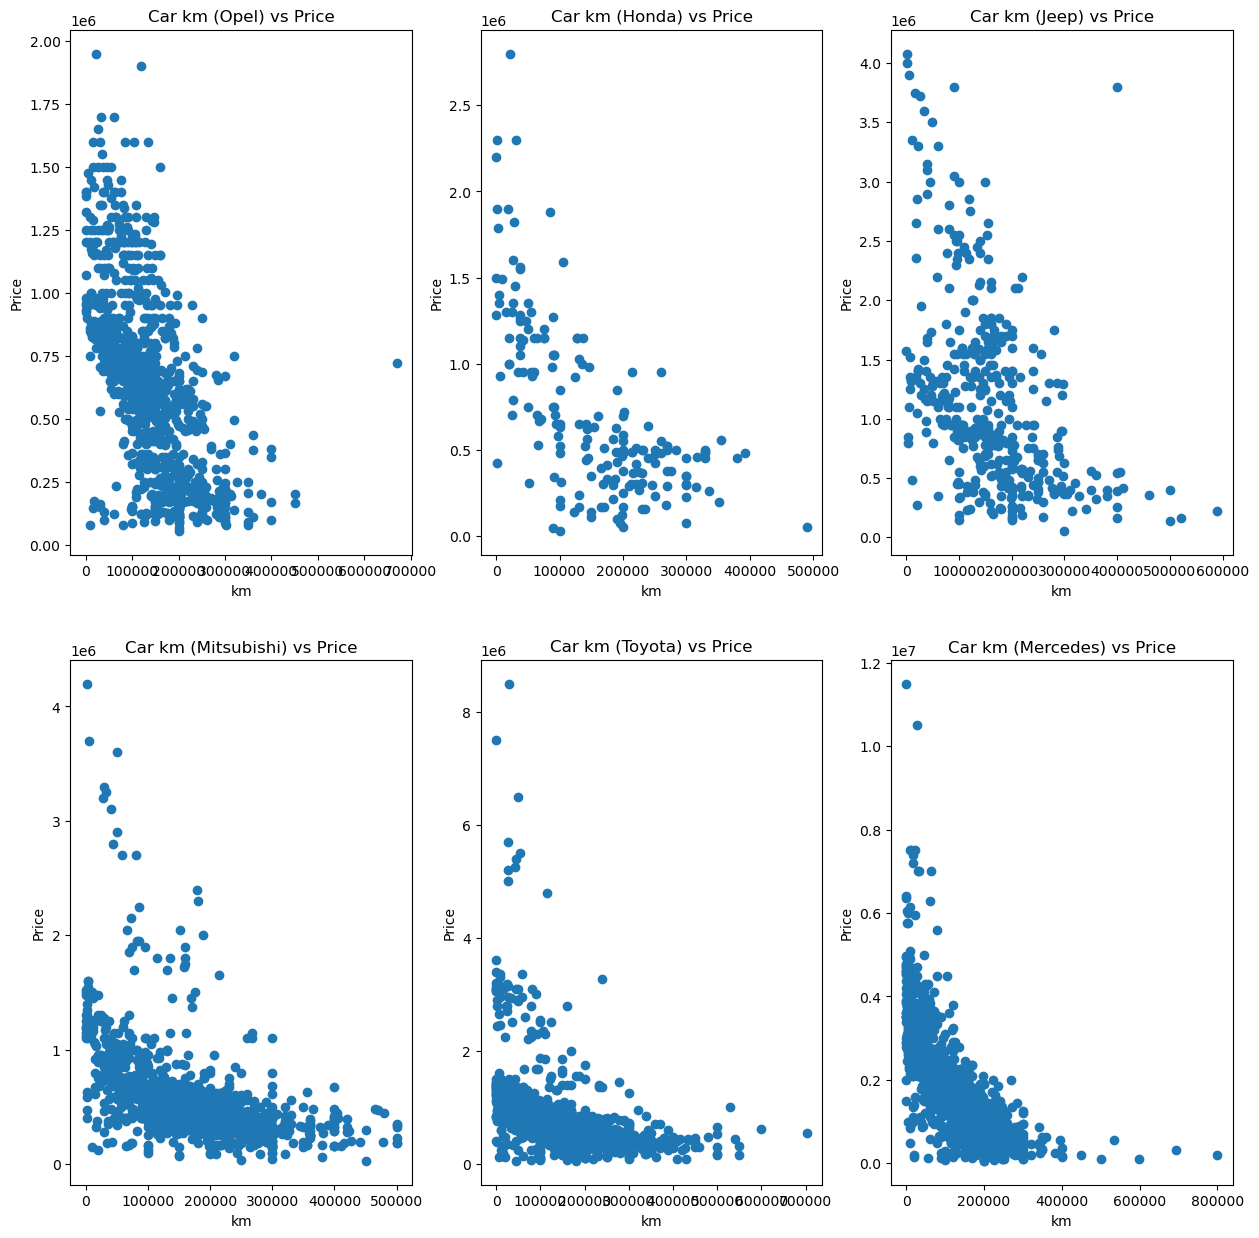

In [ ]:
plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2, 3)

plot_scatter('Opel', 'km', 0)
plot_scatter('Honda', 'km', 1)
plot_scatter('Jeep', 'km', 2)
plot_scatter('Mitsubishi', 'km', 3)
plot_scatter('Toyota', 'km', 4)
plot_scatter('Mercedes', 'km', 5)

# Categorica data preparation

## Oridnal coding of class

In [15]:
from pyspark.sql.functions import when

class_score = when(
    col("class_new")== 'standard', 0
).otherwise(1)

car_df = car_df.withColumn('class_score', class_score)
car_df.select('brand', 'model', 'class_new', 'class_score').orderBy('model').show()

+-------+-----+---------+-----------+
|  brand|model|class_new|class_score|
+-------+-----+---------+-----------+
|   Audi|  100| standard|          0|
|Renault|   11| standard|          0|
|   Fiat| 1100| standard|          0|
|   Fiat| 1100| standard|          0|
|   Fiat| 1100| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  116| standard|          0|
|    BMW|  118| standard|          0|
+-------+-----+---------+-----------+
only showing top 20 rows



### add age column

In [16]:
date = datetime.now()
year = int(date.strftime("%Y"))

car_df = car_df.withColumn('age', year+1 - car_df.model_year)


In [ ]:
"""""

pd_df = car_df.select(concat_ws(' / ', car_df.brand, car_df.model)
              .alias("brand/model"), 'transmission', 'price', 'km', 'age', 'class_score', 'body', 'fuel').toPandas()


df_onehot = pd.get_dummies(pd_df[['brand/model', 'body', 'fuel']])
pd_df = pd.concat([pd_df, df_onehot], axis=1)

car_price = np.log1p(pd_df['price'])  # Log-transform


model_df =pd_df.drop(['brand/model', 'price', 'transmission', 'body', 'fuel'], axis=1)

model_df = model_df.astype('float32')



model = Sequential()
model.add(Dense(units=150, activation='relu', input_dim=model_df.shape[1]))

model.add(Dense(units=100, activation='relu'))

model.add(Dense(units=70, activation='relu'))

model.add(Dense(units=30, activation='relu'))

model.add(Dense(units=1, activation='linear'))

# Compile the model with Mean Squared Error (MSE) as the loss function and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')
x_train, x_test, y_train, y_test = train_test_split(
model_df, car_price, test_size=0.2, random_state=0)


scaler = RobustScaler()
x_train['km'] = scaler.fit(x_train['km'].array.reshape(-1, 1)).transform(x_train['km'].array.reshape(-1, 1))
x_test['km'] = scaler.fit(x_test['km'].array.reshape(-1, 1)).transform(x_test['km'].array.reshape(-1, 1))

model.fit(x_train.values, y_train, epochs=30, batch_size=4)
"""

'""\n\npd_df = car_df.select(concat_ws(\' / \', car_df.brand, car_df.model)\n              .alias("brand/model"), \'transmission\', \'price\', \'km\', \'age\', \'class_score\', \'body\', \'fuel\').toPandas()\n\n\ndf_onehot = pd.get_dummies(pd_df[[\'brand/model\', \'body\', \'fuel\']])\npd_df = pd.concat([pd_df, df_onehot], axis=1)\n\ncar_price = np.log1p(pd_df[\'price\'])  # Log-transform\n\n\nmodel_df =pd_df.drop([\'brand/model\', \'price\', \'transmission\', \'body\', \'fuel\'], axis=1)\n\nmodel_df = model_df.astype(\'float32\')\n\n\n\nmodel = Sequential()\nmodel.add(Dense(units=150, activation=\'relu\', input_dim=model_df.shape[1]))\n\nmodel.add(Dense(units=100, activation=\'relu\'))\n\nmodel.add(Dense(units=70, activation=\'relu\'))\n\nmodel.add(Dense(units=30, activation=\'relu\'))\n\nmodel.add(Dense(units=1, activation=\'linear\'))\n\n# Compile the model with Mean Squared Error (MSE) as the loss function and Adam optimizer\nmodel.compile(loss=\'mean_squared_error\', optimizer=\'a

In [ ]:
"""""
predictions = model.predict(x_test)
r2 = r2_score(y_test, predictions)
r2
"""""

'""\npredictions = model.predict(x_test)\nr2 = r2_score(y_test, predictions)\nr2\n'

In [ ]:
"""""
plt.scatter(y_test, predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Price")
plt.show()
"""

'""\nplt.scatter(y_test, predictions)\nplt.xlabel("Actual Price")\nplt.ylabel("Predicted Price")\nplt.title("Actual vs. Predicted Price")\nplt.show()\n'

# rank model

In [26]:
brand_rank = car_df.groupBy('brand').agg(avg('price')).orderBy('avg(price)', ascending=True).toPandas()
brand_rank['rank'] = range(brand_rank.shape[0])


pd_df = car_df.select('brand', 'model', 'age', 'km', 'price', 'transmission', 'fuel', 'class_new', 'class_score').toPandas()

def rank(row):
    return brand_rank.loc[brand_rank['brand'] == row['brand'], 'rank'].iloc[0]
    

pd_df['brand_rank'] = pd_df.apply(rank, axis=1)



df_onehot = pd.get_dummies(pd_df[['model', 'fuel']])
pd_df = pd.concat([pd_df, df_onehot], axis=1)

car_price = np.log1p(pd_df['price'])  # Log-transform


model_df =pd_df.drop(['brand', 'model', 'price', 'class_new','fuel'], axis=1)

model_df = model_df.astype('float32')



model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=model_df.shape[1]))

model.add(Dense(units=70, activation='relu'))

model.add(Dense(units=35, activation='relu'))

model.add(Dense(units=1, activation='linear'))

# Compile the model with Mean Squared Error (MSE) as the loss function and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')
x_train, x_test, y_train, y_test = train_test_split(
model_df, car_price, test_size=0.2, random_state=0)


scaler = RobustScaler()
x_train['km'] = scaler.fit(x_train['km'].array.reshape(-1, 1)).transform(x_train['km'].array.reshape(-1, 1))
x_test['km'] = scaler.fit(x_test['km'].array.reshape(-1, 1)).transform(x_test['km'].array.reshape(-1, 1))

model.fit(x_train.values, y_train, epochs=30, batch_size=4)


Epoch 1/30
   1/6217 [..............................] - ETA: 16:16 - loss: 153.6039

2023-11-05 02:28:20.470272: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6217/6217 [==============================] - 4s 564us/step - loss: 0.9822
Epoch 2/30
6217/6217 [==============================] - 4s 570us/step - loss: 0.1028
Epoch 3/30
6217/6217 [==============================] - 4s 575us/step - loss: 0.0798
Epoch 4/30
6217/6217 [==============================] - 3s 548us/step - loss: 0.0679
Epoch 5/30
6217/6217 [==============================] - 3s 548us/step - loss: 0.0611
Epoch 6/30
6217/6217 [==============================] - 3s 546us/step - loss: 0.0552
Epoch 7/30
6217/6217 [==============================] - 3s 548us/step - loss: 0.0505
Epoch 8/30
6217/6217 [==============================] - 3s 548us/step - loss: 0.0503
Epoch 9/30
6217/6217 [==============================] - 3s 546us/step - loss: 0.0484
Epoch 10/30
6217/6217 [==============================] - 3s 548us/step - loss: 0.0464
Epoch 11/30
6217/6217 [==============================] - 3s 545us/step - loss: 0.0455
Epoch 12/30
6217/6217 [==============================] - 3s 551us/step - l

In [27]:
predictions = model.predict(x_test)
r2 = r2_score(y_test, predictions)
r2

195/195 [==============================] - 0s 465us/step


0.9290685016759715

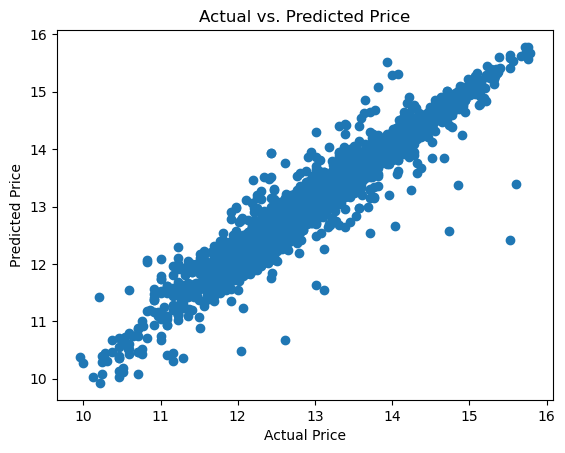

In [28]:
plt.scatter(y_test, predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Price")
plt.show()

In [29]:
ohe_features_df = pd_df.drop(['age', 'km', 'transmission', 'class_score', 'fuel'],axis=1).filter(regex="^(?!fuel)", axis=1)
ohe_fuel_df = pd_df.filter(like="fuel", axis=1).drop_duplicates(subset='fuel')
ohe_fuel_df['fuel'] = ohe_fuel_df['fuel'].replace('gas' ,'benzene')

# Save the model to a file
model.save('../models/trained_model.h5')

# Load the RobustScaler from the file
joblib.dump(scaler, '.trained_scaler.pkl')
ohe_features_df.to_pickle('../models/ohe_features.pkl')
ohe_fuel_df.to_pickle( '../models/ohe_fuel.pkl')



## Save the model

In [30]:
spark.stop()
